In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler  
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression

* This block loads the data and test/train splits

In [2]:
## Load the dataset
college_df = pd.read_csv("../data/College.csv")
college_df = college_df.set_index('Unnamed: 0')

## One-hot encode the categorical variable
college_df = pd.get_dummies(college_df, drop_first=True)

## Split into predictors and target
y = college_df['Apps']
X = college_df.drop('Apps', axis=1)

## Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

* This block does Standard Scaler

In [3]:
## Standardize

## Scale predictors 
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


* This block examines the PLS Regression model

Text(0, 0.5, 'RMS error')

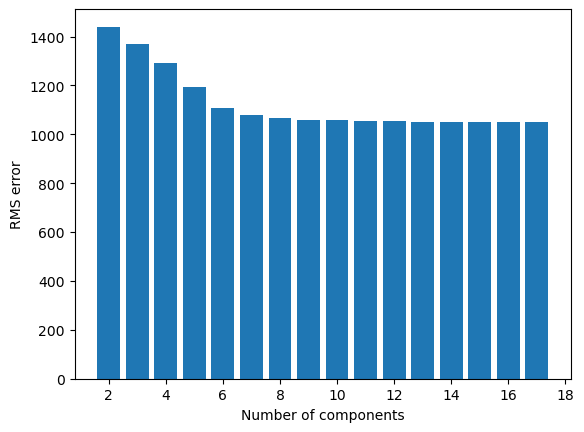

In [4]:
#Run the PLS Regression model for varying number of components
pls = PLSRegression()
cv_scores_PLS = []
for i in range(2,18):
    pls.set_params(n_components=i, tol = 0.0001)
    scores = cross_validate(pls, X_train, y_train, scoring='neg_root_mean_squared_error', n_jobs = -1)
    # default in cross_validate is 5-fold, otherwise set cv = 
    cv_scores_PLS.append(np.abs(np.mean(scores['test_score'])))
plt.bar(np.arange(2,18),cv_scores_PLS)
plt.xlabel('Number of components')
plt.ylabel('RMS error')

* Let's agree on a 5 component model 

In [5]:
pls = PLSRegression()
pls.set_params(n_components = 5, tol = 0.0001)
pls.fit(X_train,y_train)
coef = pls.score(X_test,y_test)
print(coef)



0.8629733738416636


* The best thing to do is to project the coefficients back to the data space

In [6]:
#Examine the coefficients 
model = pd.DataFrame(pls.coef_,columns = X.columns)
model.head()

,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate,Private_Yes
0,3851.349778,-104.89628,515.530896,15.489434,-169.451756,-157.000953,-440.115187,304.00459,101.120438,214.934711,-117.008878,-68.038007,33.871358,-5.301387,368.212145,8.461651,-91.951795


* But if you insist you can try to interpret the loadings. 

In [7]:
model = pd.DataFrame(np.transpose(pls.x_loadings_),columns = X.columns)
model.head()

,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate,Private_Yes
0,0.439181,0.448618,0.185045,0.215221,0.444529,0.273368,0.026269,0.085039,0.080617,0.120093,0.283332,0.273369,0.056010,-0.052536,0.126890,0.050306,-0.269195
1,0.352923,0.283009,-0.334936,-0.319594,0.232884,-0.068952,-0.223887,-0.133401,-0.031231,-0.103438,-0.636930,-0.643881,0.158708,-0.255817,-0.249837,-0.020884,0.014055
2,-0.013341,0.070048,-0.328655,-0.289260,0.117465,0.259941,-0.418577,-0.318817,0.006758,0.232594,-0.131579,-0.133883,0.313923,-0.315396,-0.347093,-0.344628,-0.315628
3,0.344197,-0.056727,-0.244884,-0.280918,-0.158671,-0.731477,-0.284153,-0.094272,-0.192153,0.065577,0.391266,0.376951,0.265220,-0.278858,-0.019421,-0.505560,-0.215970
4,0.154289,-0.188999,0.223440,0.175611,-0.195309,0.532220,-0.079181,0.040076,0.588482,0.707746,-0.318389,-0.309209,-0.298070,0.128552,0.140787,-0.054229,0.265610


* Lets compare to a PCA regression model 

In [8]:
pca = PCA()
#Here I use Linear Regression to fit after I PCA
lr = LinearRegression()
pca.fit(X_train)
X_pca = pca.transform(X_train)
lr.fit(X_pca,y_train)
X_test_pca = pca.transform(X_test)
r2  = lr.score(X_test_pca,y_test)
print(r2)




0.8606501781209519


* Following the PLS Regression lets look at different numbers of components 

Text(0, 0.5, 'RMS error')

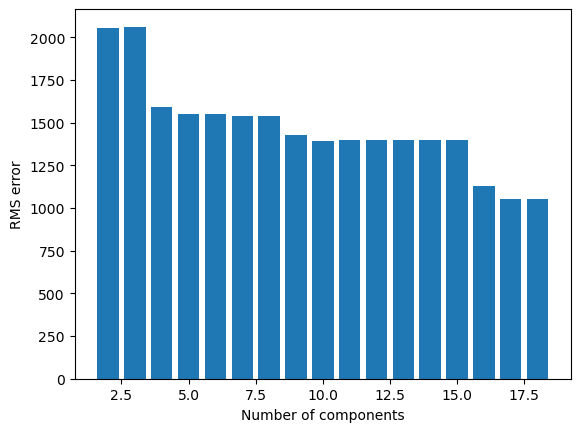

In [9]:
pca_cv = list()
for j in range(2,19):
    lrcv = LinearRegression()
    scores = cross_validate(lrcv, X_pca[:,0:j], y_train, scoring='neg_root_mean_squared_error')
    pca_cv.append(np.abs(np.mean(scores['test_score'])))
plt.bar(np.arange(2,19),pca_cv)
plt.xlabel('Number of components')
plt.ylabel('RMS error')

Finally, lets compare a 5 component model. 

In [10]:

lr5 = LinearRegression()

lr5.fit(X_pca[:,0:5],y_train)
X_test_pca = pca.transform(X_test)
r2  = lr5.score(X_test_pca[:,0:5],y_test)
print(r2)

0.7934788836620004
